In [1]:
import sys
import os 

from pathlib import Path

PROJECT_ROOT = str(Path().resolve().parent)
sys.path.append(PROJECT_ROOT)

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
price = pd.read_excel(f'{PROJECT_ROOT}/data/endog_data/mcftrr.xlsx', index_col=0)

In [4]:
returns = price.pct_change()
init_weights = (returns * 0 + 1).fillna(1).rename({'price': 'weight'}, axis=1)

In [5]:
def time_critical_weighting(init_weights, returns, decay_ratio=100, shock_quantile=0.01, shock_factor=20, shock_decay=21):
    init_weights = init_weights.copy()
    returns = returns.squeeze()

    cum_weights = init_weights.cumsum()
    alpha = np.log(decay_ratio) / len(cum_weights)
    time_weighting = np.exp(alpha * cum_weights)

    crit_dates = returns.index[np.where(returns < returns.quantile(shock_quantile))]
    gamma = np.log(decay_ratio) / shock_decay
    critical_ws = []
    for crit_date in crit_dates:
        critical_w = init_weights.loc[crit_date:]
        critical_w = critical_w.cumsum()
        critical_w = shock_factor * np.exp(-gamma * critical_w)
        critical_ws.append(critical_w)
    critical_weighting = pd.concat(critical_ws, axis=1).fillna(0).max(axis=1)
    weights = pd.concat([time_weighting, critical_weighting], axis=1).fillna(0).sum(axis=1)
    weights = weights / weights.sum()

    return weights

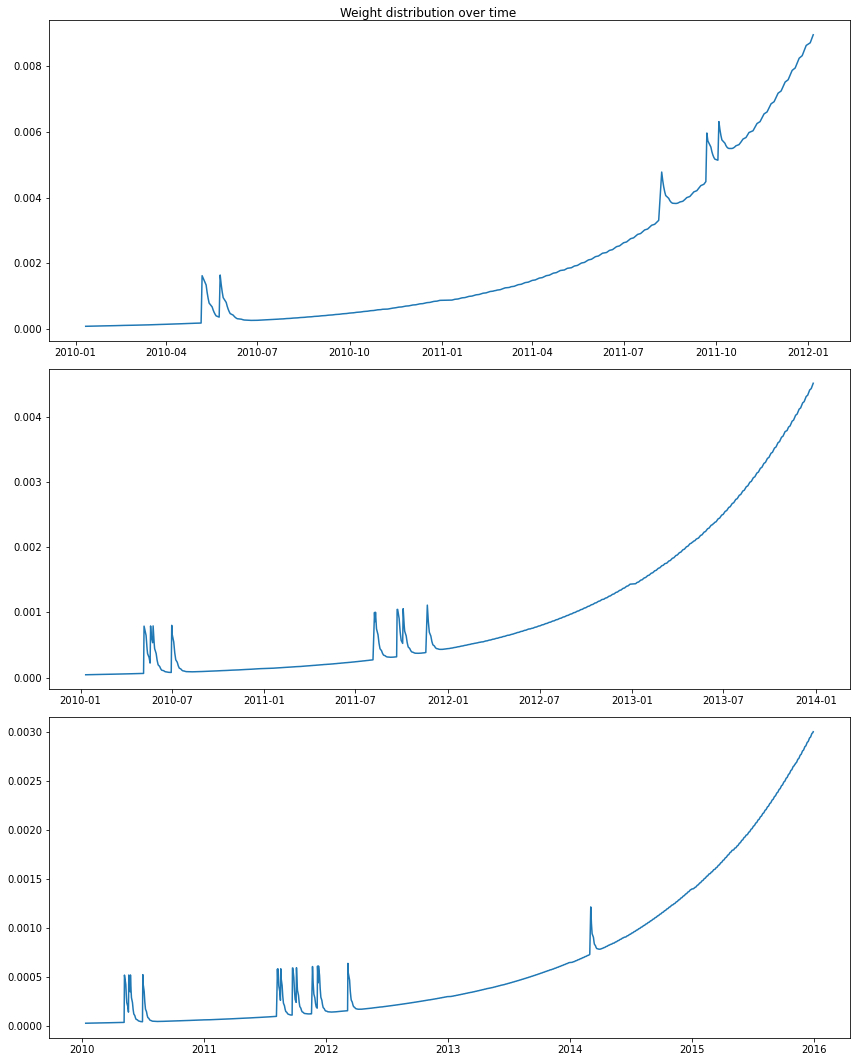

In [6]:
ns = [500, 1000, 1500]

sample_weight_kwargs = dict(
    decay_ratio=100,
    shock_quantile=0.01, 
    shock_factor=20,
    shock_decay=21
)
    
fig, ax = plt.subplots(3, figsize=(12,15))
for i, n in enumerate(ns):
    weights = time_critical_weighting(init_weights[:n], returns[:n], **sample_weight_kwargs)
    ax[i].plot(weights)
    
plt.suptitle('Weight distribution over time')
plt.tight_layout()